In [1]:
#~~~~~~~~~~~~~~ FOR GR7 ~~~~~~~~~~~~~~~


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table

calspec_File='/home/abhayprusty/Downloads/hd93521_stis_007.fits'
waveCorr_Standard_specFile='/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/wlcspec_aie07048.txt'
    
def build_instrumental_response(waveCorr_Standard_specFile, calspec_File,overwrite_bool=False):
    
    #read and retrive the standard source spectrum
    waveCorr_specData = ascii.read(waveCorr_Standard_specFile,format='fixed_width')
    instrm_wavelength = np.array(waveCorr_specData['wavelength'])
    instrm_flux = np.array(waveCorr_specData['flux'])
    instrm_fluxerr = np.array(waveCorr_specData['flux-err'])

    #print(instrm_fluxerr[0],instrm_flux[0])
    
    #Now read and retrieve the calspec spectrum
    calspec_data = fits.open(calspec_File)[1].data
    calspec_wavelength = calspec_data['WAVELENGTH']
    calspec_flux = calspec_data['FLUX']
    calspec_fluxerr = calspec_data['STATERROR']

    #Now we need to interpolate the calspec spectrum at the lcoation of the inetrument wavelengths
    #given the higher resolutuon of the 
    calspecFLUX_interpOn_intrumWavelength = np.interp(x=instrm_wavelength, xp=calspec_wavelength, fp=calspec_flux)
    calspecFLUX_ERR_interpOn_intrumWavelength = np.interp(x=instrm_wavelength, xp=calspec_wavelength, fp=calspec_fluxerr)
    
    #let's scale down the spectrum for the sake of calculational simplicity
    median_calspec_flux = np.median(calspecFLUX_interpOn_intrumWavelength)
    #median_calspec_flux_err = np.median(calspecFLUX_ERR_interpOn_intrumWavelength)

    calspecFLUX_interpOn_intrumWavelength /= median_calspec_flux
    calspecFLUX_ERR_interpOn_intrumWavelength /= median_calspec_flux
    
    #Now since the CALSPEC and instrumental flux are written on the same wavelength, we can divide one by the other 
    #to retrieve the instrument response function (IRF)
    instru_response_function = np.divide(instrm_flux,calspecFLUX_interpOn_intrumWavelength)
    
    #We need to error propagate the flux error; errorIRF/IRF

    
    errorIRF_IRF = (np.divide(instrm_fluxerr,instrm_flux))**2 + (np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
    #errorIRF_IRF_s = (np.divide(instrm_fluxerr,instrm_flux))**2 +(np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
    #errorIRF_IRF= np.sqrt(errorIRF_IRF_s)
    errorIRF = np.sqrt(errorIRF_IRF) * instru_response_function

    #print(f"IRF has nans --> {np.isnan(instru_response_function)}")

    med_irf = np.median(instru_response_function)

    #print(errorIRF_IRF[0],errorIRF[0])
    
    #Now this can be median normalized to get a instrument response function
    IRF = instru_response_function / med_irf
    IRF_err = errorIRF / med_irf
    
    #Now this file can be used to write a dat file
    IRF_table = Table()
    IRF_table['Wavelength (A)'] = np.array(instrm_wavelength)
    IRF_table['Flux'] = np.array(IRF)
    IRF_table['Flux-Err'] = np.array(IRF_err)
    
    IRF_table.meta['comments'] = "It contains median normalized instrument response function (IRF) for a given night \n IRF is calculated by dividing the standard source spectrum by the CALSPEC spectrum \n error propagation has been taken care of \n".splitlines()
    
    locs_table = os.path.dirname(waveCorr_Standard_specFile) + '/IRF_' + os.path.basename(waveCorr_Standard_specFile)
    print(f"IRF path --> {locs_table}")
    #save the IRF table
    if not os.path.exists(locs_table):
        ascii.write(IRF_table,locs_table,format='fixed_width',overwrite=overwrite_bool)
    elif os.path.exists(locs_table) and overwrite_bool == True:
        ascii.write(IRF_table,locs_table,format='fixed_width',overwrite=overwrite_bool)
        
    return IRF_table



In [14]:

build_instrumental_response(waveCorr_Standard_specFile, calspec_File, overwrite_bool=True)


IRF path --> /home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/IRF_wlcspec_aie07048.txt


/tmp/ipykernel_5911/2602118874.py:49: RuntimeWarning: divide by zero encountered in divide
  errorIRF_IRF = (np.divide(instrm_fluxerr,instrm_flux))**2 + (np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
/tmp/ipykernel_5911/2602118874.py:52: RuntimeWarning: invalid value encountered in multiply
  errorIRF = np.sqrt(errorIRF_IRF) * instru_response_function


Wavelength (A),Flux,Flux-Err
float64,float64,float64
2787.7365731315867,0.0002487814590404281,1.8237771479785486e-05
2788.92422145644,0.010076982807208772,0.001387444920181232
2790.1120602549126,0.0,nan
2791.3000895040977,-0.00010124891931564736,-7.591685724612136e-05
2792.4883091810716,1.8829405007122148e-05,2.377962209020783e-05
2793.676719262937,2.227298496407437e-05,1.4863583768291234e-05
2794.8653197267604,0.0010753325958624846,4.243407512965079e-05
2796.054110549634,0.0012105519106407226,4.732796368322846e-05
2797.243091708632,0.0003088577175420308,0.0001325222227226592


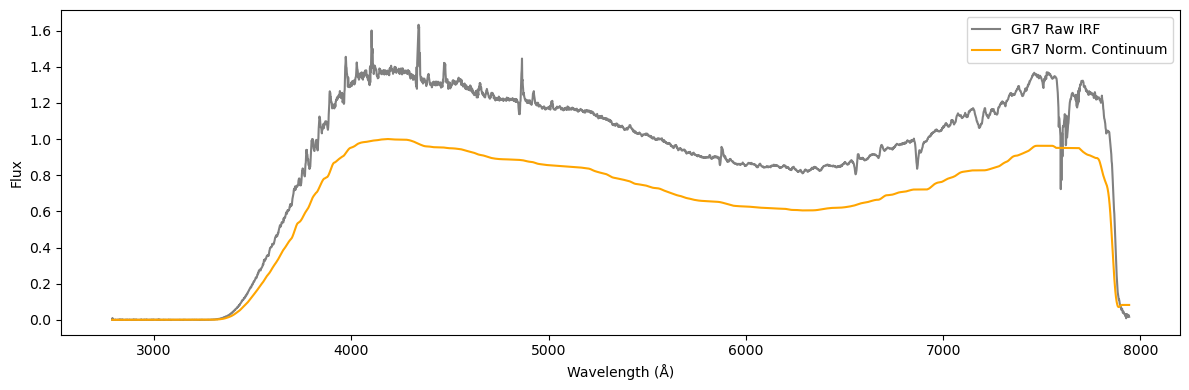

 GR7 normalized IRF saved at: /home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/gr7_norm_con_IRF_wlcspec_aie07048.txt


In [15]:
from astropy.io import ascii
from astropy.table import Table
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import percentile_filter
import matplotlib.pyplot as plt

def build_IRFContinuum(spectrum, wavelength, deg_polyfit=9, mask_regions=None):
    fluxArr = np.array(spectrum)
    wavelengthArr = np.array(wavelength)

    if mask_regions is not None:
        mask = np.ones(wavelengthArr.shape, dtype=bool)
        for start, end in mask_regions:
            mask &= ~((wavelengthArr >= start) & (wavelengthArr <= end))
        wl_fit = wavelengthArr[mask]
        flux_fit = fluxArr[mask]
    else:
        wl_fit = wavelengthArr
        flux_fit = fluxArr

    percent_filtered = percentile_filter(flux_fit, percentile=45, size=int(len(flux_fit) / 25))
    window = int(len(percent_filtered) / 100)
    if window % 2 == 0:
        window += 1
    smoothed_continuum_fit = savgol_filter(percent_filtered, window_length=window, polyorder=3)

    continuum = np.interp(wavelengthArr, wl_fit, smoothed_continuum_fit)
    return continuum

# --- GR7 IRF path ---
irf_path_gr7 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/IRF_wlcspec_aie07048.txt'

# --- Read GR7 IRF ---
irf_gr7 = ascii.read(irf_path_gr7, format='fixed_width')
wavelength_gr7 = np.array(irf_gr7['Wavelength (A)'])
flux_gr7 = np.array(irf_gr7['Flux'])

# --- Copy IRF to modify ---
irf_gr7_copy = irf_gr7.copy()

mask_regions = [
    (6847, 6918),
    (7146, 7207),
    (7573, 7688)
]

# --- Build and normalize continuum for gr7 ---
continuum_gr7 = build_IRFContinuum(flux_gr7, wavelength_gr7, mask_regions=mask_regions)
norm_continuum_gr7 = continuum_gr7 / np.max(continuum_gr7) #writing this normalised IRF continuum in a table
irf_gr7_copy['Flux'] = norm_continuum_gr7

# --- Save normalized GR7 IRF ---
output_path_gr7 = irf_path_gr7.replace('IRF_', 'gr7_norm_con_IRF_')
#ascii.write(irf_gr7_copy, output_path_gr7, format='fixed_width')

plt.figure(figsize=(12, 4))
plt.plot(wavelength_gr7, flux_gr7, label='GR7 Raw IRF', color='gray')
#plt.plot(wavelength_gr7, continuum_gr7, label='GR7 Continuum only ', color='orange')
plt.plot(wavelength_gr7, norm_continuum_gr7, label='GR7 Norm. Continuum', color='orange')

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.tight_layout()
plt.show()

print(f" GR7 normalized IRF saved at: {output_path_gr7}")

In [16]:
#~~~~~~~~~~~~~~ FOR GR8 ~~~~~~~~~~~~~~~


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table

calspec_File='/home/abhayprusty/Downloads/hd93521_stis_007.fits'
waveCorr_Standard_specFile='/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/wlcspec_aie07049.txt'
    
def build_instrumental_response(waveCorr_Standard_specFile, calspec_File,overwrite_bool=False):
    
    #read and retrive the standard source spectrum
    waveCorr_specData = ascii.read(waveCorr_Standard_specFile,format='fixed_width')
    instrm_wavelength = np.array(waveCorr_specData['wavelength'])
    instrm_flux = np.array(waveCorr_specData['flux'])
    instrm_fluxerr = np.array(waveCorr_specData['flux-err'])

    #print(instrm_fluxerr[0],instrm_flux[0])
    
    #Now read and retrieve the calspec spectrum
    calspec_data = fits.open(calspec_File)[1].data
    calspec_wavelength = calspec_data['WAVELENGTH']
    calspec_flux = calspec_data['FLUX']
    calspec_fluxerr = calspec_data['STATERROR']

    #Now we need to interpolate the calspec spectrum at the lcoation of the inetrument wavelengths
    #given the higher resolutuon of the 
    calspecFLUX_interpOn_intrumWavelength = np.interp(x=instrm_wavelength, xp=calspec_wavelength, fp=calspec_flux)
    calspecFLUX_ERR_interpOn_intrumWavelength = np.interp(x=instrm_wavelength, xp=calspec_wavelength, fp=calspec_fluxerr)
    
    #let's scale down the spectrum for the sake of calculational simplicity
    median_calspec_flux = np.median(calspecFLUX_interpOn_intrumWavelength)
    #median_calspec_flux_err = np.median(calspecFLUX_ERR_interpOn_intrumWavelength)

    calspecFLUX_interpOn_intrumWavelength /= median_calspec_flux
    calspecFLUX_ERR_interpOn_intrumWavelength /= median_calspec_flux
    
    #Now since the CALSPEC and instrumental flux are written on the same wavelength, we can divide one by the other 
    #to retrieve the instrument response function (IRF)
    instru_response_function = np.divide(instrm_flux,calspecFLUX_interpOn_intrumWavelength)
    
    #We need to error propagate the flux error; errorIRF/IRF

    
    errorIRF_IRF = (np.divide(instrm_fluxerr,instrm_flux))**2 + (np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
    #errorIRF_IRF_s = (np.divide(instrm_fluxerr,instrm_flux))**2 +(np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
    #errorIRF_IRF= np.sqrt(errorIRF_IRF_s)
    errorIRF = np.sqrt(errorIRF_IRF) * instru_response_function

    #print(f"IRF has nans --> {np.isnan(instru_response_function)}")

    med_irf = np.median(instru_response_function)

    #print(errorIRF_IRF[0],errorIRF[0])
    
    #Now this can be median normalized to get a instrument response function
    IRF = instru_response_function / med_irf
    IRF_err = errorIRF / med_irf
    
    #Now this file can be used to write a dat file
    IRF_table = Table()
    IRF_table['Wavelength (A)'] = np.array(instrm_wavelength)
    IRF_table['Flux'] = np.array(IRF)
    IRF_table['Flux-Err'] = np.array(IRF_err)
    
    IRF_table.meta['comments'] = "It contains median normalized instrument response function (IRF) for a given night \n IRF is calculated by dividing the standard source spectrum by the CALSPEC spectrum \n error propagation has been taken care of \n".splitlines()
    
    locs_table = os.path.dirname(waveCorr_Standard_specFile) + '/IRF_' + os.path.basename(waveCorr_Standard_specFile)
    print(f"IRF path --> {locs_table}")
    #save the IRF table
    if not os.path.exists(locs_table):
        ascii.write(IRF_table,locs_table,format='fixed_width',overwrite=overwrite_bool)
    elif os.path.exists(locs_table) and overwrite_bool == True:
        ascii.write(IRF_table,locs_table,format='fixed_width',overwrite=overwrite_bool)
        
    return IRF_table



In [17]:

build_instrumental_response(waveCorr_Standard_specFile, calspec_File, overwrite_bool=True)


IRF path --> /home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/IRF_wlcspec_aie07049.txt


/tmp/ipykernel_5911/3662577710.py:49: RuntimeWarning: divide by zero encountered in divide
  errorIRF_IRF = (np.divide(instrm_fluxerr,instrm_flux))**2 + (np.divide(calspecFLUX_ERR_interpOn_intrumWavelength,calspecFLUX_interpOn_intrumWavelength))**2
/tmp/ipykernel_5911/3662577710.py:52: RuntimeWarning: invalid value encountered in multiply
  errorIRF = np.sqrt(errorIRF_IRF) * instru_response_function


Wavelength (A),Flux,Flux-Err
float64,float64,float64
4907.959371328279,0.0027280074233293553,0.00026270110840231507
4909.014944134855,0.0008059828250209908,0.00011431133015202875
4910.070583527138,0.003394406877926738,0.0001419932042605197
4911.1262895584205,0.001700766034196879,0.00013349984706668107
4912.182062282,0.0031298492767433436,0.0001558917838261733
4913.2379017511885,0.0020199474343141986,0.00017930902694916922
4914.293808019282,-0.009351977918895566,-0.004597916414645229
4915.3497811395955,0.0037450249475348375,0.00024661123610890157
4916.405821165423,0.0022581322931036815,0.00019433001926919178


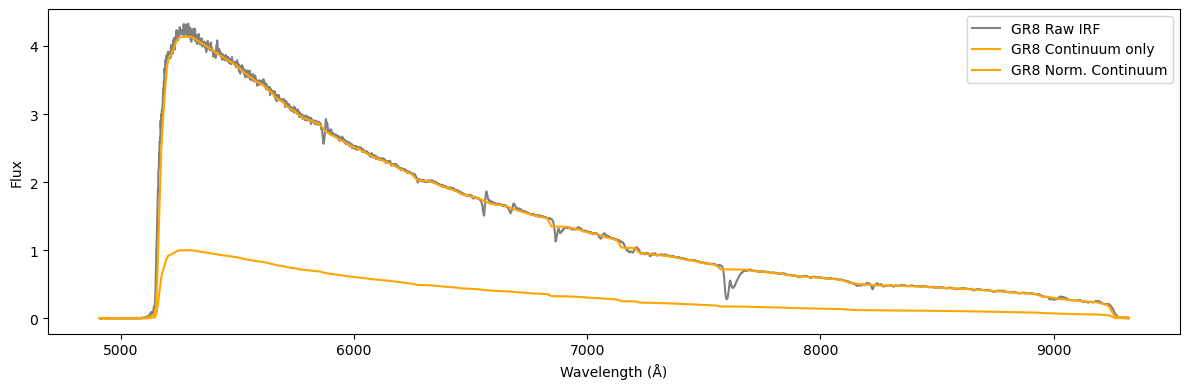

GR8 normalized IRF saved at: /home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/gr8_norm_con_IRF_wlcspec_aie07049.txt


In [1]:
from astropy.io import ascii
from astropy.table import Table
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import percentile_filter
import matplotlib.pyplot as plt

def build_IRFContinuum(spectrum, wavelength, deg_polyfit=9, mask_regions=None):
    fluxArr = np.array(spectrum)
    wavelengthArr = np.array(wavelength)

    if mask_regions is not None:
        mask = np.ones(wavelengthArr.shape, dtype=bool)
        for start, end in mask_regions:
            mask &= ~((wavelengthArr >= start) & (wavelengthArr <= end))
        wl_fit = wavelengthArr[mask]
        flux_fit = fluxArr[mask]
    else:
        wl_fit = wavelengthArr
        flux_fit = fluxArr

    percent_filtered = percentile_filter(flux_fit, percentile=45, size=int(len(flux_fit) / 25))
    window = int(len(percent_filtered) / 100)
    if window % 2 == 0:
        window += 1
    smoothed_continuum_fit = savgol_filter(percent_filtered, window_length=window, polyorder=3)

    continuum = np.interp(wavelengthArr, wl_fit, smoothed_continuum_fit)
    return continuum

# --- GR8 IRF path ---
irf_path_gr8 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/IRF_wlcspec_aie07049.txt'

# --- Read GR8 IRF ---
irf_gr8 = ascii.read(irf_path_gr8, format='fixed_width')
wavelength_gr8 = np.array(irf_gr8['Wavelength (A)'])
flux_gr8 = np.array(irf_gr8['Flux'])

# --- Copy IRF to modify ---
irf_gr8_copy = irf_gr8.copy()

mask_regions = [
    (6847, 6918),
    (7146, 7207),
    (7573, 7688)
]

# --- Build and normalize continuum for GR8 ---
continuum_gr8 = build_IRFContinuum(flux_gr8, wavelength_gr8, mask_regions=mask_regions)
norm_continuum_gr8 = continuum_gr8 / np.max(continuum_gr8)
irf_gr8_copy['Flux'] = norm_continuum_gr8

# --- Save normalized GR8 IRF ---
output_path_gr8 = irf_path_gr8.replace('IRF_', 'gr8_norm_con_IRF_')
#ascii.write(irf_gr8_copy, output_path_gr8, format='fixed_width')

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.plot(wavelength_gr8, flux_gr8, label='GR8 Raw IRF', color='gray')
plt.plot(wavelength_gr8, continuum_gr8, label='GR8 Continuum only', color='orange')
plt.plot(wavelength_gr8, norm_continuum_gr8, label='GR8 Norm. Continuum', color='orange')

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.tight_layout()
plt.show()
print(f"GR8 normalized IRF saved at: {output_path_gr8}")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
%matplotlib widget
from scipy.signal import savgol_filter

calspec='/home/abhayprusty/Downloads/hd93521_stis_007.fits'
irf_path_gr7 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/gr7_norm_con_IRF_wlcspec_aie07048.txt'  
irf_path_gr8 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/gr8_norm_con_IRF_wlcspec_aie07049.txt'  
spec_path_gr7 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/wlcspec_aie07048.txt'
spec_path_gr8 = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/stdstar/wlcspec_aie07049.txt'


In [3]:
#~~~~ FOR CALASPEC ~~~~~~~~~~~~~~
calspec_data = fits.open(calspec)[1].data
calspec_data = calspec_data[(calspec_data['WAVELENGTH'] > 4000) & (calspec_data['WAVELENGTH'] < 9000)]
calspec_wavelength = calspec_data['WAVELENGTH']
calspec_flux = calspec_data['FLUX']*10**11
calspec_fluxerr = calspec_data['STATERROR']


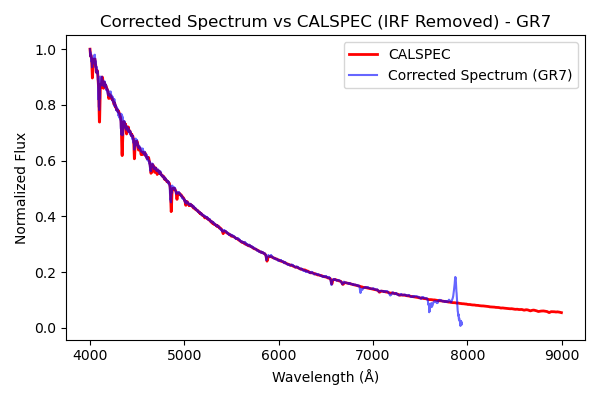

In [4]:
# --- Load spectrum and IRF data for GR7 ---
spec_irf_data7 = ascii.read(spec_path_gr7, format='fixed_width')
spec_irf_data7 = spec_irf_data7[(spec_irf_data7['wavelength'] > 4000) & (spec_irf_data7['wavelength'] < 8000)]
wl_spec7 = spec_irf_data7['wavelength']
flux_spec7 = spec_irf_data7['flux']

irf_data7 = ascii.read(irf_path_gr7, format='fixed_width')
wl_irf7 = irf_data7['Wavelength (A)']
flux_irf7 = irf_data7['Flux']

# --- GR7 Correction ---
irf_interp7 = np.interp(wl_spec7, wl_irf7, flux_irf7)
flux_corrected7 = flux_spec7 / irf_interp7
flux_corrected_norm7 = flux_corrected7 / np.max(flux_corrected7)

# --- Normalize CALSPEC for comparison ---
calspec_flux_norm = calspec_flux / np.max(calspec_flux)

# --- Plot GR7 vs CALSPEC ---
plt.figure(figsize=(6, 4))
plt.plot(calspec_wavelength, calspec_flux_norm, label='CALSPEC', color='r', linewidth=2)
plt.plot(wl_spec7, flux_corrected_norm7, label='Corrected Spectrum (GR7)', color='b', alpha=0.6)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Flux')
plt.title('Corrected Spectrum vs CALSPEC (IRF Removed) - GR7')
plt.legend()
#plt.grid(True)
plt.tight_layout()
#plt.savefig("Corrected_Spectrum_vs_CALSPEC_GR7.png")
plt.show()



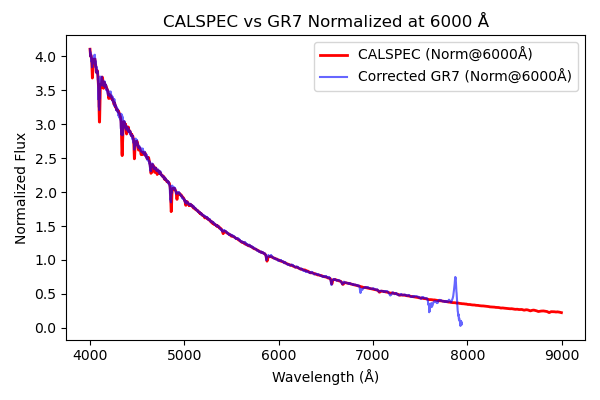

In [5]:
# --- Interpolate around reference wavelength (6000 ± 50 Å) ---
ref_wl = 6000
delta = 50

# --- CALSPEC mean flux near 6000 Å ---
calspec_at_ref = np.mean(calspec_flux_norm[(calspec_wavelength > ref_wl - delta) & (calspec_wavelength < ref_wl + delta)])

# --- Corrected GR7 flux mean near 6000 Å ---
corrected_at_ref_gr7 = np.mean(flux_corrected_norm7[(wl_spec7 > ref_wl - delta) & (wl_spec7 < ref_wl + delta)])

# --- Normalize both with their respective values at 6000 Å ---
calspec_flux_norm_gr7 = calspec_flux_norm / calspec_at_ref
flux_corrected_norm_gr7 = flux_corrected_norm7 / corrected_at_ref_gr7

# --- Plotting ---
plt.figure(figsize=(6, 4))
plt.plot(calspec_wavelength, calspec_flux_norm_gr7, label='CALSPEC (Norm@6000Å)', color='r', linewidth=2)
plt.plot(wl_spec7, flux_corrected_norm_gr7, label='Corrected GR7 (Norm@6000Å)', color='b', alpha=0.6)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Flux')
plt.title('CALSPEC vs GR7 Normalized at 6000 Å')
plt.legend()
plt.tight_layout()
plt.show()


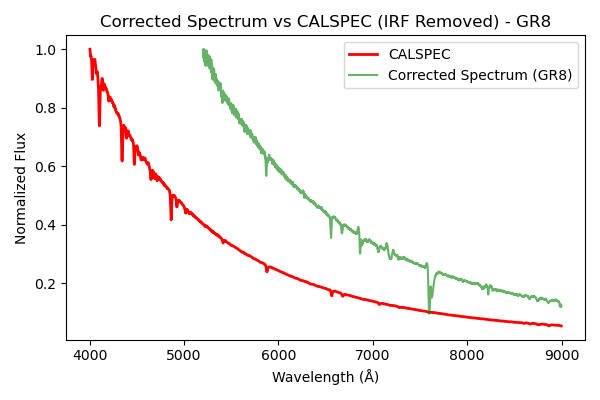

In [6]:
# --- Load spectrum and IRF data for GR8 ---
spec_irf_data8 = ascii.read(spec_path_gr8, format='fixed_width')
spec_irf_data8 = spec_irf_data8[(spec_irf_data8['wavelength'] > 5202) & (spec_irf_data8['wavelength'] < 9000)]
wl_spec8 = spec_irf_data8['wavelength']
flux_spec8 = spec_irf_data8['flux']

irf_data8 = ascii.read(irf_path_gr8, format='fixed_width')
wl_irf8 = irf_data8['Wavelength (A)']
flux_irf8 = irf_data8['Flux']

# --- GR8 Correction ---
irf_interp8 = np.interp(wl_spec8, wl_irf8, flux_irf8)
flux_corrected8 = flux_spec8 / irf_interp8
flux_corrected_norm8 = flux_corrected8 / np.max(flux_corrected8)

# --- Plot GR8 vs CALSPEC ---
plt.figure(figsize=(6, 4))
plt.plot(calspec_wavelength, calspec_flux_norm, label='CALSPEC', color='r', linewidth=2)
plt.plot(wl_spec8, flux_corrected_norm8, label='Corrected Spectrum (GR8)', color='g', alpha=0.6)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Flux')
plt.title('Corrected Spectrum vs CALSPEC (IRF Removed) - GR8')
plt.legend()
#plt.grid(True)
plt.tight_layout()
#plt.savefig("Corrected_Spectrum_vs_CALSPEC_GR8.png")
plt.show()



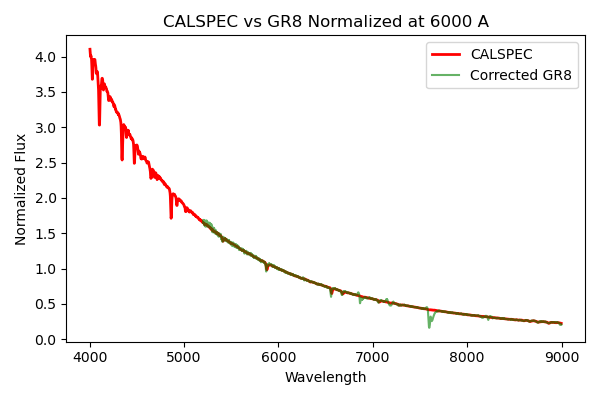

In [7]:
# --- Interpolate around reference wavelength ---
ref_wl = 6000
delta = 50

# --- Corrected GR8 flux mean near 6000 Å ---
corrected_at_ref_gr8 = np.mean(flux_corrected_norm8[(wl_spec8 > ref_wl - delta) & (wl_spec8 < ref_wl + delta)])

# --- Normalize both CALSPEC and GR8 using 6000 Å region ---
calspec_flux_norm_gr8 = calspec_flux_norm / calspec_at_ref   # reuse calspec_at_ref from GR7 block
flux_corrected_norm_gr8 = flux_corrected_norm8 / corrected_at_ref_gr8

plt.figure(figsize=(6, 4))
plt.plot(calspec_wavelength, calspec_flux_norm_gr8, label='CALSPEC', color='r', linewidth=2)
plt.plot(wl_spec8, flux_corrected_norm_gr8, label='Corrected GR8', color='g', alpha=0.6)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('CALSPEC vs GR8 Normalized at 6000 A')
plt.legend()
plt.tight_layout()
plt.show()


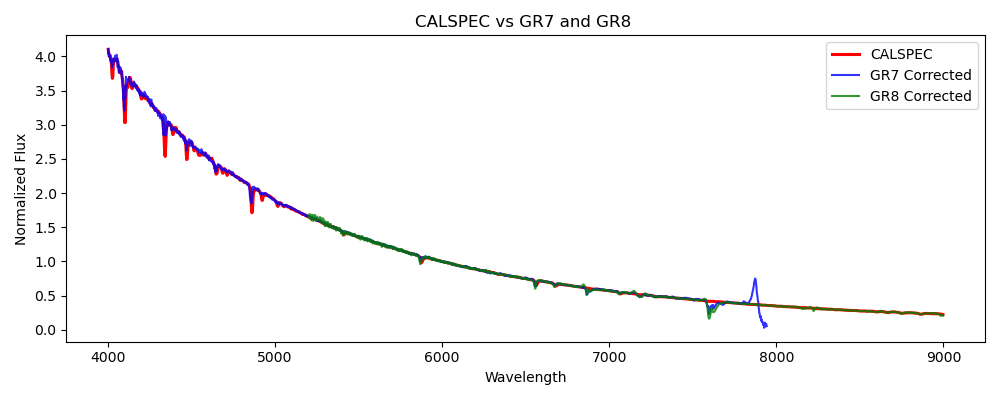

In [8]:
ref_wl = 6000
delta = 50

# --- Get CALSPEC normalization at 6000 ± 50  ---
calspec_at_ref = np.mean(calspec_flux_norm[(calspec_wavelength > ref_wl - delta) & (calspec_wavelength < ref_wl + delta)])
calspec_flux_norm1 = calspec_flux_norm / calspec_at_ref

# --- GR7 normalization ---
corrected_at_ref_gr7 = np.mean(flux_corrected_norm7[(wl_spec7 > ref_wl - delta) & (wl_spec7 < ref_wl + delta)])
flux_corrected_norm_gr7 = flux_corrected_norm7 / corrected_at_ref_gr7

# --- GR8 normalization ---
corrected_at_ref_gr8 = np.mean(flux_corrected_norm8[(wl_spec8 > ref_wl - delta) & (wl_spec8 < ref_wl + delta)])
flux_corrected_norm_gr8 = flux_corrected_norm8 / corrected_at_ref_gr8

# --- Plot all three ---
plt.figure(figsize=(10,4))
plt.plot(calspec_wavelength, calspec_flux_norm1, label='CALSPEC', color='r', linewidth=2.2)
plt.plot(wl_spec7, flux_corrected_norm_gr7, label='GR7 Corrected', color='blue', alpha=0.8)
plt.plot(wl_spec8, flux_corrected_norm_gr8, label='GR8 Corrected', color='green', alpha=0.8)

plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('CALSPEC vs GR7 and GR8 ')
plt.legend()
plt.savefig('CALSPEC vs GR7 and GR8 corrected')
plt.tight_layout()
plt.show()
